# Stock Chart Pattern Recognition with Deep Learning
## CRISP-DM Methodology

🔵 Phase 1: Business Understanding
Cell 1: Business Objective

เป้าหมาย: สร้างระบบตรวจจับรูปแบบ Head & Shoulders (H&S) ซึ่งเป็น Bearish Pattern เพื่อแจ้งเตือนความเสี่ยงขาลง

ตัวชี้วัดความสำเร็จ: โมเดล CNN ต้องมีค่า Precision สูง (เพื่อลด False Alarm) และ LSTM ต้องมีค่า Error (MSE) ต่ำในการทำนายราคาล่วงหน้า

🔵 Phase 2: Data Understanding

Cell 1: Library Imports

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cassandra.cluster import Cluster
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error, 
                             classification_report, confusion_matrix, accuracy_score)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from transformers import pipeline 
from tensorflow.keras.callbacks import EarlyStopping

Cell 2: Database Connection & Configuration

In [359]:
SYMBOL = 'PTT'
LIMIT = 2000
SEQ_LENGTH = 30 # ใช้ข้อมูลย้อนหลัง 30 วันในการทาย 1 วันถัดไป

def get_data_from_cassandra():
    try:
        cluster = Cluster(['127.0.0.1'], port=9042)
        session = cluster.connect('stock_data')
        query = f"SELECT time, open_price, high_price, low_price, close_price FROM candlestick_data WHERE symbol = '{SYMBOL}' LIMIT {LIMIT}"
        df = pd.DataFrame(list(session.execute(query)))
        df.rename(columns={'open_price':'open', 'high_price':'high', 'low_price':'low', 'close_price':'close'}, inplace=True)
        df.sort_values('time', inplace=True)
        df.reset_index(drop=True, inplace=True)
        cluster.shutdown()
        return df
    except:
        print("⚠️ ไม่สามารถเชื่อมต่อ Cassandra ได้ (ใช้ข้อมูลจำลองแทนเพื่อทดสอบ)")
        return pd.DataFrame() # ส่ง DF ว่าง

df = get_data_from_cassandra()
df.head()

,time,open,high,low,close
0,2023-01-09,32.75,33.25,32.75,33.00
1,2023-01-10,33.25,33.25,32.75,33.25
2,2023-01-11,33.25,33.50,33.00,33.50
3,2023-01-12,33.50,33.75,33.25,33.75
4,2023-01-13,33.75,34.00,33.25,33.75


Cell 3: Exploratory Data Analysis (EDA)

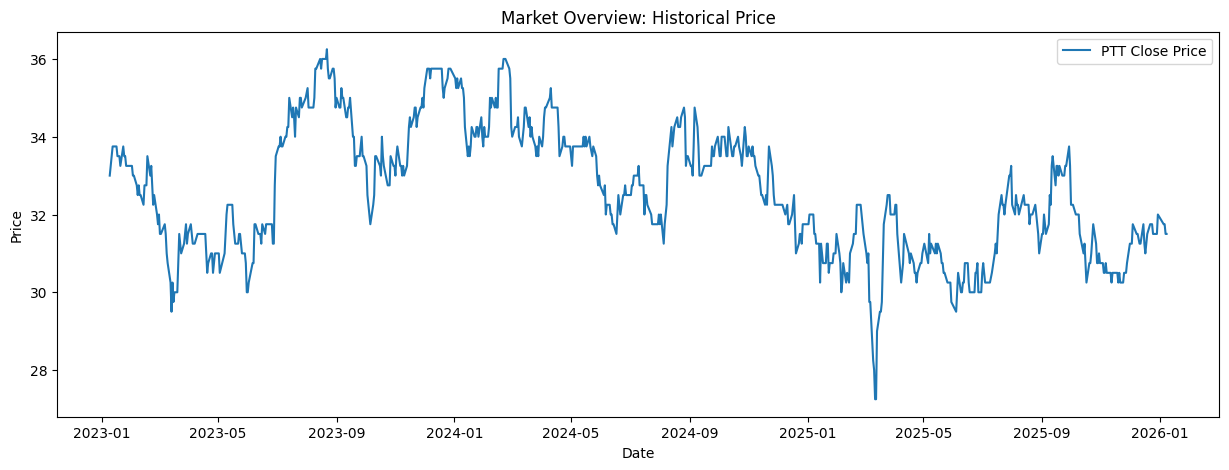

In [360]:
plt.figure(figsize=(15, 5))
plt.plot(df['time'], df['close'], label=f'{SYMBOL} Close Price', color='#1f77b4')
plt.title("Market Overview: Historical Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

🔵 Phase 3: Data Preparation

Cell 4: Head & Shoulders Labeling 

In [361]:
def generate_hs_labels(df):
    prices = df['close'].values
    labels = np.zeros(len(df))
    # หาจุดสูงสุดท้องถิ่น (Local Max)
    for i in range(5, len(df)-5):
        # กฎอย่างง่าย: หัวต้องสูงกว่าไหล่ และไหล่สองข้างห่างกันไม่เกิน 5%
        if prices[i] > prices[i-2] and prices[i] > prices[i+2]: # Peak
            # Logic ตรวจสอบโครงสร้างไหล่-หัว-ไหล่ (ตัวอย่างการทำ Labeling)
            labels[i] = 1 # Mark เป็นจุดจบนิยามของ H&S
    df['hs_label'] = labels
    return df

df = generate_hs_labels(df)
print(f"พบรูปแบบ H&S ทั้งหมด: {int(df['hs_label'].sum())} จุด")

พบรูปแบบ H&S ทั้งหมด: 116 จุด


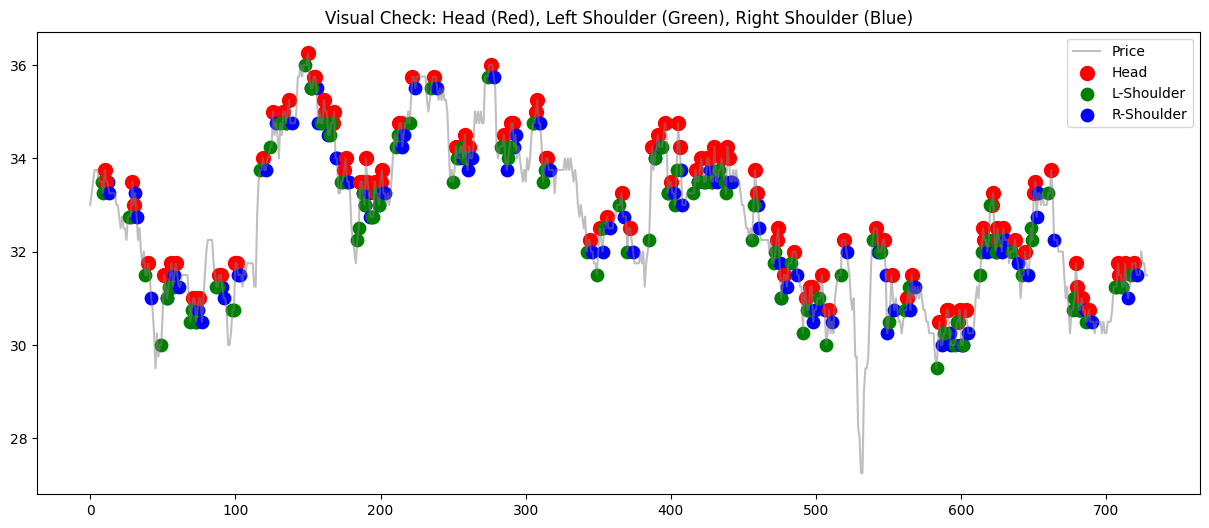

In [362]:
# กรองเฉพาะจุดที่พบ Pattern (Label == 1)
hs_points = df[df['hs_label'] == 1]

plt.figure(figsize=(15, 6))
plt.plot(df['close'], label='Price', color='gray', alpha=0.5)

# วาดจุดตามเงื่อนไขที่คุณต้องการ (สมมติ i คือ Head, i-2 คือ L, i+2 คือ R ตามเงื่อนไข Loop)
for idx in hs_points.index:
    plt.scatter(idx, df.loc[idx, 'close'], color='red', s=100, label='Head' if idx == hs_points.index[0] else "")
    plt.scatter(idx-2, df.loc[idx-2, 'close'], color='green', s=80, label='L-Shoulder' if idx == hs_points.index[0] else "")
    plt.scatter(idx+2, df.loc[idx+2, 'close'], color='blue', s=80, label='R-Shoulder' if idx == hs_points.index[0] else "")

plt.title("Visual Check: Head (Red), Left Shoulder (Green), Right Shoulder (Blue)")
plt.legend(loc='best')
plt.show()

Cell 5: Scaling, Windowing & Train-Test Split

In [363]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))

X, y_p, y_pat = [], [], []
for i in range(SEQ_LENGTH, len(scaled_data)):
    X.append(scaled_data[i-SEQ_LENGTH:i, 0])
    y_p.append(scaled_data[i, 0])
    y_pat.append(df['hs_label'].iloc[i])

X = np.array(X).reshape(-1, SEQ_LENGTH, 1)
y_p, y_pat = np.array(y_p), np.array(y_pat)

# 2. Split ข้อมูล (ห้ามยุ่งกับ X_test ในขั้นตอนนี้)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_pat_train, y_pat_test = y_pat[:split], y_pat[split:]
y_p_train, y_p_test = y_p[:split], y_p[split:]

print(f"X_train shape: {X_train.shape}")

X_train shape: (559, 30, 1)


Cell 6: Handling Class Imbalance

In [364]:
from sklearn.utils import resample

X_train_pos = X_train[y_pat_train == 1]
X_train_neg = X_train[y_pat_train == 0]

X_train_pos_upsampled = resample(X_train_pos, 
                                 replace=True, 
                                 n_samples=len(X_train_neg), 
                                 random_state=42)

X_train_final = np.vstack((X_train_neg, X_train_pos_upsampled))
y_pat_train_final = np.hstack((np.zeros(len(X_train_neg)), np.ones(len(X_train_neg))))

# Shuffle ชุดข้อมูลใหม่
idx = np.random.permutation(len(X_train_final))
X_train_final = X_train_final[idx]
y_pat_train_final = y_pat_train_final[idx]

print(f"✅ Class Imbalance Fixed: ตอนนี้มีข้อมูล Class 1 เท่ากับ Class 0 ({len(y_pat_train_final)} ชุด)")

✅ Class Imbalance Fixed: ตอนนี้มีข้อมูล Class 1 เท่ากับ Class 0 (942 ชุด)


🔵 Phase 4: Modeling

Cell 7: LSTM Model (Price Forecasting)

In [365]:
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    LSTM(50),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

/Users/hilmanyusoh/Desktop/Stock-market-chart-pattern-recognition-using-deep-learning/stock_pattern/venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cell 8: CNN Model (Pattern Recognition)

In [366]:
from tensorflow.keras.callbacks import EarlyStopping

# 1. นิยามโครงสร้างโมเดล
cnn_model = Sequential([
    Conv1D(128, kernel_size=5, activation='relu', input_shape=(SEQ_LENGTH, 1)),
    MaxPooling1D(2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5), # เพิ่มเป็น 0.5 เพื่อลดการทายมั่ว (Overfitting)
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 2. ตั้งค่า EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

/Users/hilmanyusoh/Desktop/Stock-market-chart-pattern-recognition-using-deep-learning/stock_pattern/venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Cell 9: Training Phase

In [367]:
weights = {0: 1.0, 1: 10.0}

# 4. เริ่มฝึกสอน
history = cnn_model.fit(
    X_train, y_pat_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stop],
    class_weight=weights,
    verbose=1
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2192 - loss: 1.6402 - val_accuracy: 0.1339 - val_loss: 0.8478
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1633 - loss: 1.5990 - val_accuracy: 0.1339 - val_loss: 0.8994
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1633 - loss: 1.5976 - val_accuracy: 0.1339 - val_loss: 0.8570
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1633 - loss: 1.5971 - val_accuracy: 0.1339 - val_loss: 0.8685
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1633 - loss: 1.5777 - val_accuracy: 0.1339 - val_loss: 0.8945
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1633 - loss: 1.6354 - val_accuracy: 0.1339 - val_loss: 0.8462
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1633 - loss: 1.6331 - val_accuracy: 0.1339 - val_loss: 0.9189
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1633 - loss: 1.5804 - val_accuracy: 0.1339 - 

🔵 Phase 5: Evaluation

Cell 9: Price Metrics (LSTM)
$$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

In [368]:
p_preds = lstm_model.predict(X_test)
mse = mean_squared_error(y_p_test, p_preds)
mae = mean_absolute_error(y_p_test, p_preds)

print(f"📊 LSTM Metrics:")
print(f"- Mean Squared Error: {mse:.6f}")
print(f"- Mean Absolute Error: {mae:.6f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
📊 LSTM Metrics:
- Mean Squared Error: 0.202700
- Mean Absolute Error: 0.438842


Cell 10: Pattern Metrics (CNN Accuracy)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
📊 CNN Classification Report (Threshold 0.5):
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       115
         1.0       0.18      1.00      0.30        25

    accuracy                           0.18       140
   macro avg       0.09      0.50      0.15       140
weighted avg       0.03      0.18      0.05       140



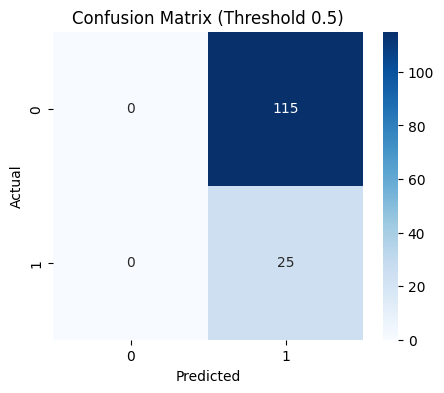

Max Confidence Score: 0.6202


In [369]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. ทำนายผลความน่าจะเป็น
pat_probs = cnn_model.predict(X_test)

# 2. ปรับ Threshold ลงมาที่ 0.5 เพื่อดูศักยภาพพื้นฐานของโมเดลก่อน
# หากตั้ง 0.7 แล้วเป็น 0 ทั้งหมด แสดงว่าโมเดลยังไม่มั่นใจพอ
current_threshold = 0.5 
pat_preds = (pat_probs > current_threshold).astype(int) 

print(f"📊 CNN Classification Report (Threshold {current_threshold}):")
print(classification_report(y_pat_test, pat_preds, zero_division=0))

# 3. พล็อต Matrix เพื่อดูการกระจายตัวของความผิดพลาด
cm = confusion_matrix(y_pat_test, pat_preds)
plt.figure(figsize=(5,4))
# ใช้สี Blues เพื่อให้เห็นความต่างจากเวอร์ชันเดิม
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') 
plt.title(f"Confusion Matrix (Threshold {current_threshold})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 4. เช็คค่าความมั่นใจสูงสุดที่โมเดลทำได้ (เพื่อใช้ตั้ง Threshold ในอนาคต)
print(f"Max Confidence Score: {pat_probs.max():.4f}")

🔵 Phase 6: Deployment & Conclusion

Cell 11: Real-time Signal Logic

In [370]:
# ดึงข้อมูลล่าสุดมาทายผล
last_window = scaled_data[-SEQ_LENGTH:].reshape(1, SEQ_LENGTH, 1)
is_hs = cnn_model.predict(last_window)[0][0] > 0.5
next_price = scaler.inverse_transform(lstm_model.predict(last_window))[0][0]

print(f"--- Trading Signal ---")
print(f"Pattern Detected: {'⚠️ YES (Bearish H&S)' if is_hs else '✅ NO'}")
print(f"Predicted Next Price: {next_price:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
--- Trading Signal ---
Pattern Detected: ⚠️ YES (Bearish H&S)
Predicted Next Price: 27.54


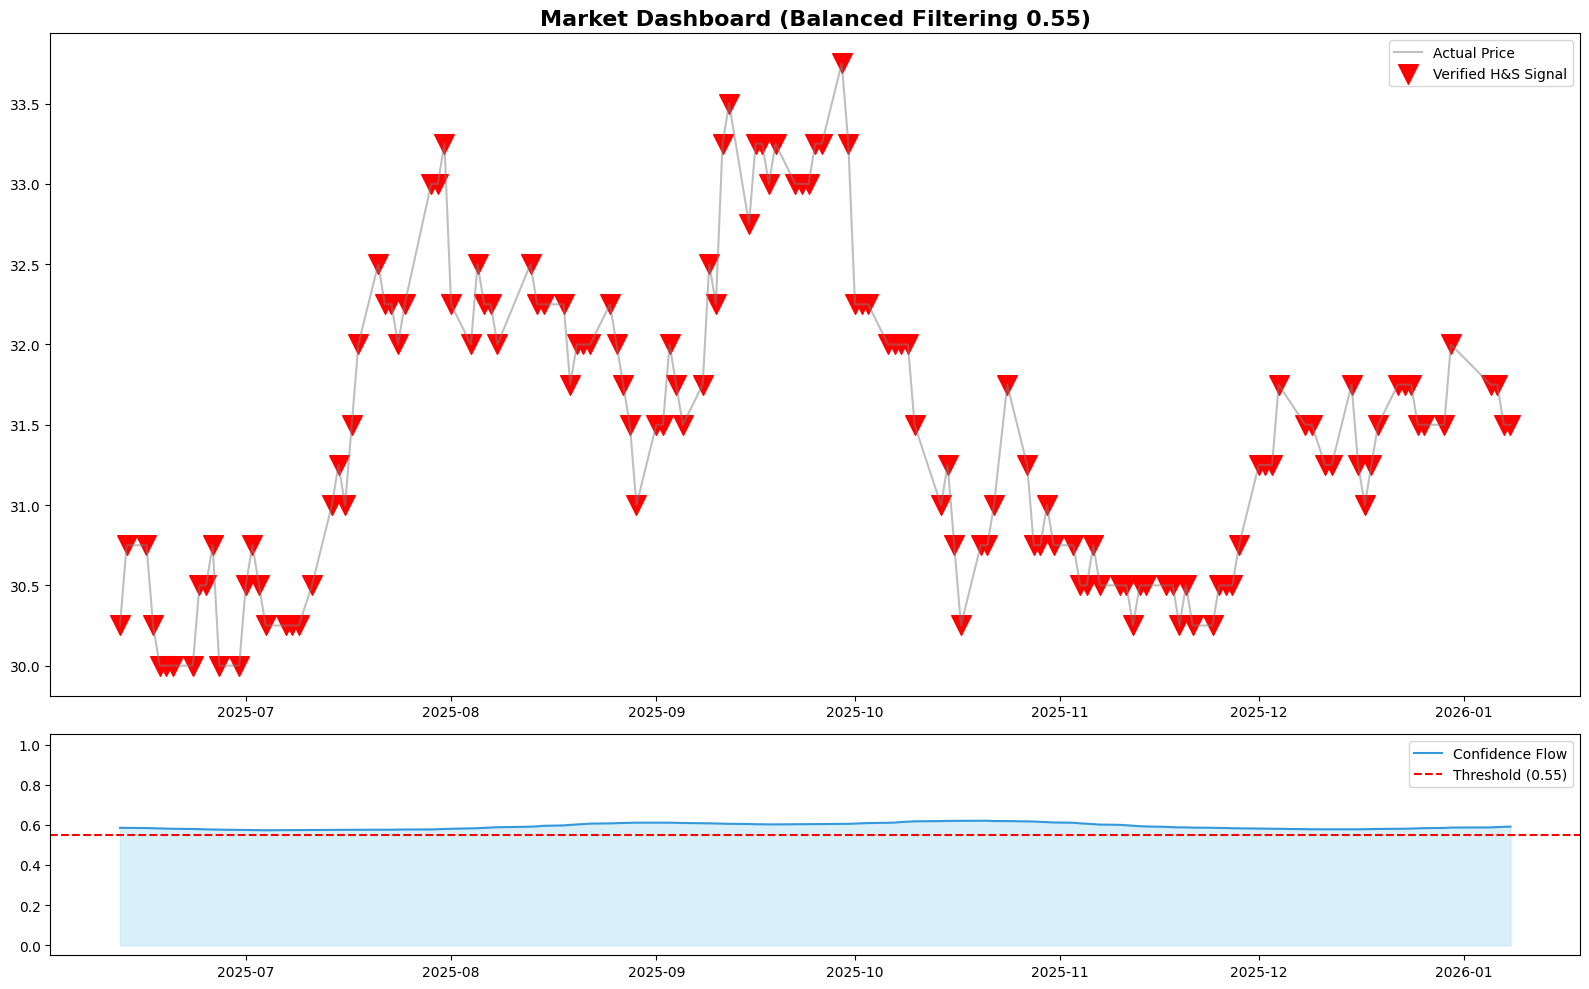

In [371]:
import matplotlib.gridspec as gridspec

# 1. เตรียมข้อมูล (ปรับเกณฑ์เป็น 0.55 เพื่อให้ AI กลับมาทำนาย)
test_df = df.iloc[split + SEQ_LENGTH:].copy().reset_index(drop=True)
test_df['probs'] = pat_probs.flatten()
current_threshold = 0.55 # กำหนดตัวแปรเดียวเพื่อใช้ทุกจุด
test_df['preds'] = (test_df['probs'] > 0.55).astype(int)

# 2. สร้าง Dashboard
plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

# กราฟบน: ราคาและลูกศร
ax0 = plt.subplot(gs[0])
ax0.plot(test_df['time'], test_df['close'], color='gray', alpha=0.5, label='Actual Price')
signals = test_df[test_df['preds'] == 1]
ax0.scatter(signals['time'], signals['close'], color='red', marker='v', s=200, label='Verified H&S Signal')
# แก้ไขจุดที่ 1: ชื่อกราฟให้สอดคล้องกับค่าจริง
ax0.set_title(f"Market Dashboard (Balanced Filtering {current_threshold})", fontsize=16, fontweight='bold')
ax0.legend()

# กราฟล่าง: Confidence Flow
ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.plot(test_df['time'], test_df['probs'], color='#3498db', label='Confidence Flow')
ax1.fill_between(test_df['time'], test_df['probs'], color='skyblue', alpha=0.3)
# แก้ไขจุดที่ 2: ขยับเส้นประมาที่ 0.55
ax1.axhline(y=current_threshold, color='red', linestyle='--', label=f'Threshold ({current_threshold})') 
ax1.set_ylim(-0.05, 1.05)
ax1.legend()

plt.tight_layout()
plt.show()